In [1]:
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
!git clone https://github.com/nanekja/pytorch_utils

fatal: destination path 'pytorch_utils' already exists and is not an empty directory.


In [3]:
from __future__ import print_function

import torch
import torch.optim as optim
import torchvision
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, OneCycleLR, ReduceLROnPlateau

!pip install albumentations
!pip install torchsummary
!pip install tqdm
!pip install torchinfo torch_lr_finder

import os
import sys 
%matplotlib inline
import matplotlib.pyplot as plt
import torch_lr_finder as lr

sys.path.append('./pytorch_utils/')
import main
import utils
import transform
#import custom_resnet
import train1
import test1
import dataloader
import albumentation
from gradcam import GradCAM,visualize_cam

sys.path.append('./pytorch_utils/models/')
import c_resnet


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


/home/nanekja/.local/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/home/nanekja/.local/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = utils.get_device()
print(device)

cpu


In [5]:
mean, std = utils.get_mean_and_std()

Files already downloaded and verified
 - Dataset Numpy Shape: (50000, 32, 32, 3)
 - Min: [0. 0. 0.]
 - Max: [1. 1. 1.]
 - Mean: [0.49139968 0.48215841 0.44653091]
 - Std: [0.24703223 0.24348513 0.26158784]
 - Var: [15.56135559 15.11767693 17.44919073]


Files already downloaded and verified


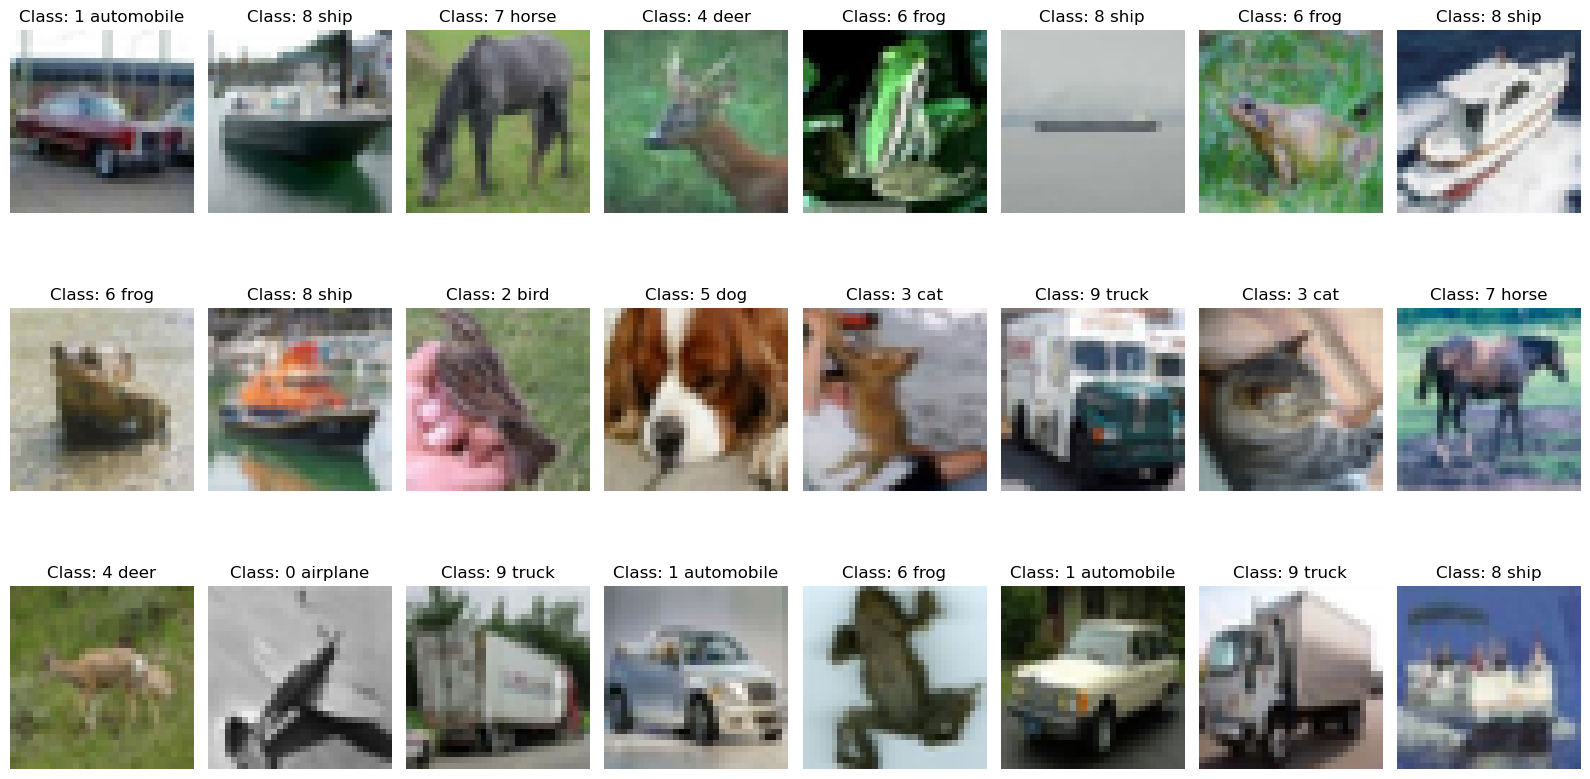

In [6]:
exp = torchvision.datasets.CIFAR10('./data', train=True, download=True)
utils.plot_data(exp,3,8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 32, 32])
torch.Size([32])


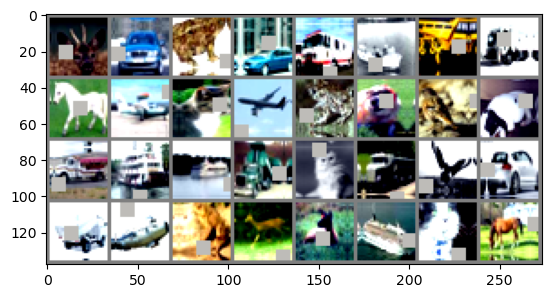

In [7]:
dataiter = iter(transform.train_loader)

images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

# show images
utils.imshow(torchvision.utils.make_grid(images))

In [8]:
from models import c_resnet

model = c_resnet.Net().to(device)

!pip install torchscan --no-deps
from torchscan import summary

summary(model, (3, 32, 32), receptive_field=True, max_depth=1)

Defaulting to user installation because normal site-packages is not writeable


  0%|          | 0/400 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.15E+00


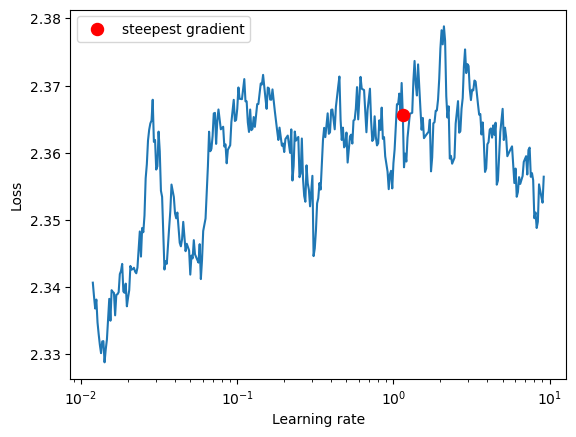

In [9]:
#lrmax=0.01
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
#optimizer = optim.Adam(model.parameters(), lr=lrmax)

optimizer = optim.SGD(model.parameters(), lr=0.00001,momentum=0.9 ,weight_decay = 0.0005)

lr_finder = lr.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(transform.train_loader, val_loader=transform.test_loader, end_lr=1, num_iter=500 ,step_mode="exp")


#utils.find_lr(model, optimizer, criterion, transform.train_loader)
lr_finder.plot()

In [ ]:
ideal_lr = utils.ler_rate(model, optimizer, criterion, transform.train_loader)
ideal_lr

In [10]:
#Train again with one cycle policy now
#EPOCHS = 24
#max_epoch=5

#scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
#scheduler = OneCycleLR(optimizer,max_lr= 0.2, steps_per_epoch=steps_per_epoch,epochs=epochs, pct_start=pct_start,div_factor=10,final_div_factor=10,verbose=False)
#scheduler = OneCycleLR(optimizer=optimizer, max_lr=lrmax, epochs=EPOCHS, steps_per_epoch=len(transform.train_loader), pct_start=max_epoch/EPOCHS, div_factor=10)
optimizer = optim.SGD(model.parameters(), lr=ideal_lr, momentum=0.9,weight_decay=0.0001, nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, patience = 2)

In [11]:
EPOCHS = 2

net, history = main.fit_model(model, device, transform.train_loader, transform.test_loader, optimizer, criterion, scheduler, EPOCHS)

EPOCH: 1 (LR: 0.0009999999999999992)


Batch_id=1562 Loss=2.21824 Accuracy=23.55: 100%|██████████| 1563/1563 [23:15<00:00,  1.12it/s]



Test set: Average loss: -0.2467, Accuracy: 2463/10000 (24.63%)

EPOCH: 2 (LR: 0.0018596362224731506)


Batch_id=1562 Loss=2.22811 Accuracy=23.09: 100%|██████████| 1563/1563 [19:40<00:00,  1.32it/s]



Test set: Average loss: -0.2557, Accuracy: 2556/10000 (25.56%)



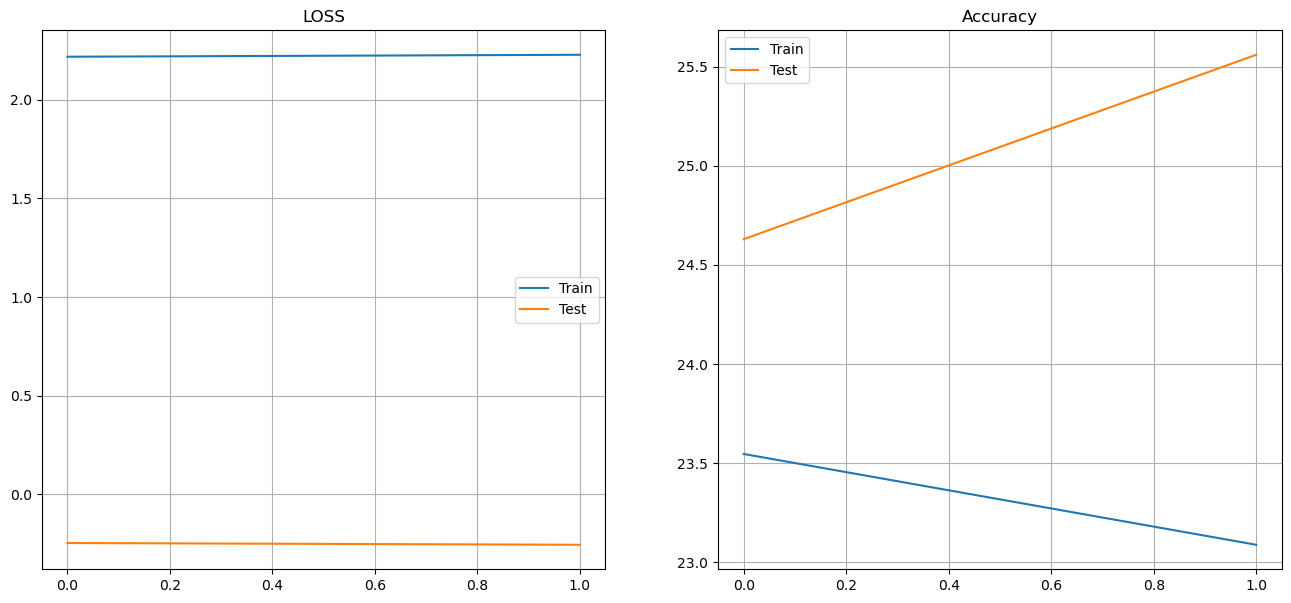

In [12]:
utils.result_graphs(history)

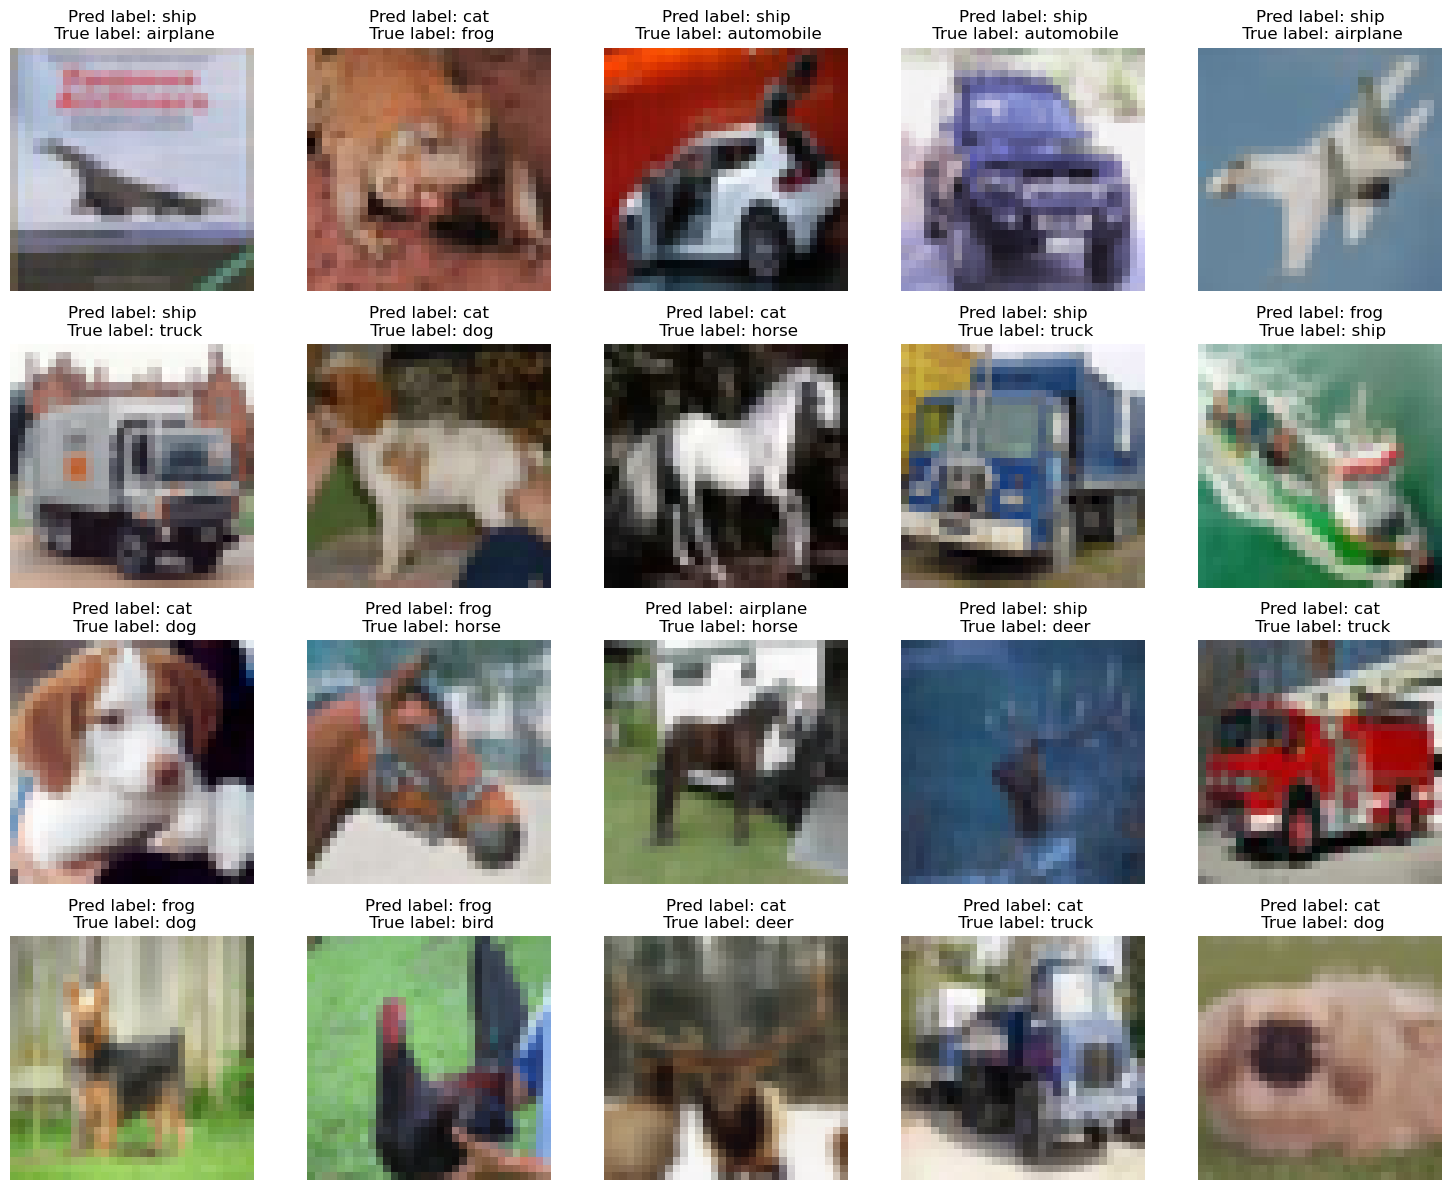

In [13]:
misclf = utils.plot_misclassified(net, transform.test_loader, transform.testset.classes, device, mean, std, return_misclf=True)

In [ ]:
total_images = 25
gradcam_misclassified_images = utils.get_misclassified_images(model, device, transform.test_loader, transform.testset.classes, total_images)

In [ ]:
import copy
from torchvision.utils import make_grid, save_image
for i,k in enumerate(gradcam_misclassified_images):
  images1 = [gradcam_misclassified_images[i][0].cpu()]
  images2 =  [gradcam_misclassified_images[i][0].cpu()]
  b = copy.deepcopy(model.to(device))
  #b = copy.deepcopy(model)
  output = model(gradcam_misclassified_images[i][0].unsqueeze(0))
  _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [b.prep_layer,b.layer1,b.layer2,b.layer3]
  for j in layers:
    g = GradCAM(b,j)
    # mask, _= g(gradcam_misclassified_images[i][0].unsqueeze(0))
    # heatmap, result = visualize_cam(mask,gradcam_misclassified_images[i][0])
    mask, _= g(gradcam_misclassified_images[i][0].clone().unsqueeze_(0))
    heatmap, result = visualize_cam(mask,gradcam_misclassified_images[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5)
  # imshow(grid_image,c = classes[int(predicted)])
  utils.imshow(grid_image,c = "P={}, A={}".format(str(transform.testset.classes[gradcam_misclassified_images[i][1].data.cpu().numpy()]),str(transform.testset.classes[gradcam_misclassified_images[i][2].data.cpu().numpy()])))